In [1]:
import math

import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset
from copy import deepcopy
import torch.nn
import torchvision.transforms as transforms
import torchvision
from NetworkWrapper import *
from Dataloader import *
import numpy as np
import math
import cv2
from torchsummary import summary
import time
import os
import shutil
import datetime

# Setting Up The Dataloader

In [2]:
train_set = OpenCVDataset(mode="train",
                          transform=None,
                          pre_transform=torch.Tensor,
                          data_dir="processed",
                          filter_success=True,
                          col_ranges=[[" AU01_r"," AU45_c"]])

val_set = OpenCVDataset(mode="test",
                        transform=None,
                        pre_transform=torch.Tensor,
                        data_dir="processed",
                        filter_success=True,
                        col_ranges=[[" AU01_r"," AU45_c"]])

(21523, 35)
Pre-Transforming Data
Finished Pre-Transforming.
(5357, 35)
Pre-Transforming Data
Finished Pre-Transforming.


# Creating out network
Creating a network structure using nn.Sequential.
When we call the forward method, it goes through these one by one.

In [3]:
class Squeeze(nn.Module):
    def __init__(self):
        super(Squeeze, self).__init__()

        self.squeeze = torch.squeeze

    def forward(self, data):
        return self.squeeze(data)

## It seems that dropout layers do not improve accuracy.
deep_cnn = nn.Sequential(
    nn.Linear(35, 140),
    nn.ReLU(),

    nn.Linear(140, 140*2),
    nn.ReLU(),

    nn.Linear(140*2, 7),
)




# Printing the summary of our network
summary(deep_cnn.cuda(), (0,35))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 0, 140]           5,040
              ReLU-2               [-1, 0, 140]               0
            Linear-3               [-1, 0, 280]          39,480
              ReLU-4               [-1, 0, 280]               0
            Linear-5                 [-1, 0, 7]           1,967
Total params: 46,487
Trainable params: 46,487
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.18
Estimated Total Size (MB): 0.18
----------------------------------------------------------------


In [4]:
# Defining the actual model to use our structure defined earlier
DeepCNN = NN(deep_cnn)

# Defining out optimiser and schedulers
optimiser = torch.optim.Adam(DeepCNN.parameters(), lr=0.0001, weight_decay=0.001)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.1)

# Defining our network wrapper.
DefinedCNN = DefinedNN(DeepCNN,
                       n_classes=len(DefinedNN.classes()),
                       loss_function=nn.CrossEntropyLoss(),
                       optimiser=optimiser,
                       lr_scheduler=lr_scheduler,
                       device="cuda:0",
                       )

# Starting Tensorboard
Specify output directory and then run the code below.
After, navigate to http://localhost:6006/

In [5]:
tensorboard_dir = 'runs/'

DefinedCNN.start_tensorboard(tensorboard_dir + "AU_Test/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

projector_data, projector_labels = train_set.__getitem__(list(torch.randint(low=0, high=len(train_set.labels)+1, size=(100,))))
projector_labels = [DefinedCNN.classes[label] for label in projector_labels]

DefinedCNN.add_embedding(mat=projector_data,
                         metadata=projector_labels,
                         tag="AU_Test_" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

%load_ext tensorboard
%tensorboard --logdir={tensorboard_dir}  --host=localhost --reload_interval=30






time_start = time.time()
DefinedCNN.train(train_set=train_set, val_set=val_set, max_epoch=30)
print(f"Took {time.time() - time_start}s to train")

# Training it

Iteration Progress: [30/30]
Maxmimum Validation Accuracy:0.6283367556468172
Took 20.513479709625244s to train


In [ ]:

# Graphing statistics
fig = DefinedCNN.graph()


# Loading a model
The network wrapper keeps track of all the parameters and scores during training. You can access these models by accessing the self.states variable.
The wrapper automatically extracts 3 of the best states for us, they are respectively called "val_loss", "train_loss", and "val_acc".

val_loss = model with lowest validation loss
train_loss = model with lowest training loss
val_acc = model with highest validation accuracy.

In [ ]:
# Loading model with highest val acc
DefinedCNN.load_model("val_acc")

# Testing out newly loaded model with the val set to initialise necessary data.
sorted_pred = DefinedCNN.test_model(val_set)

# Confusion Matrix and Occlusion Sensitivity

## Confusion Matrix

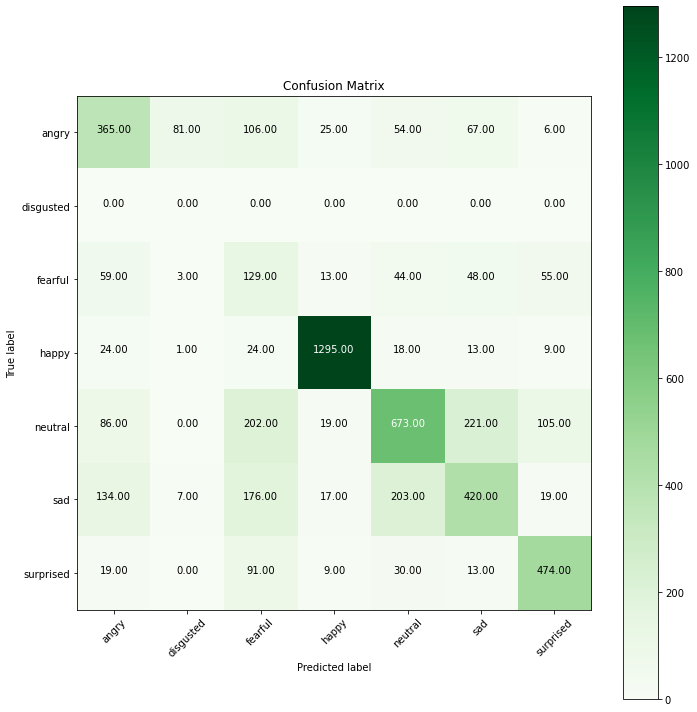

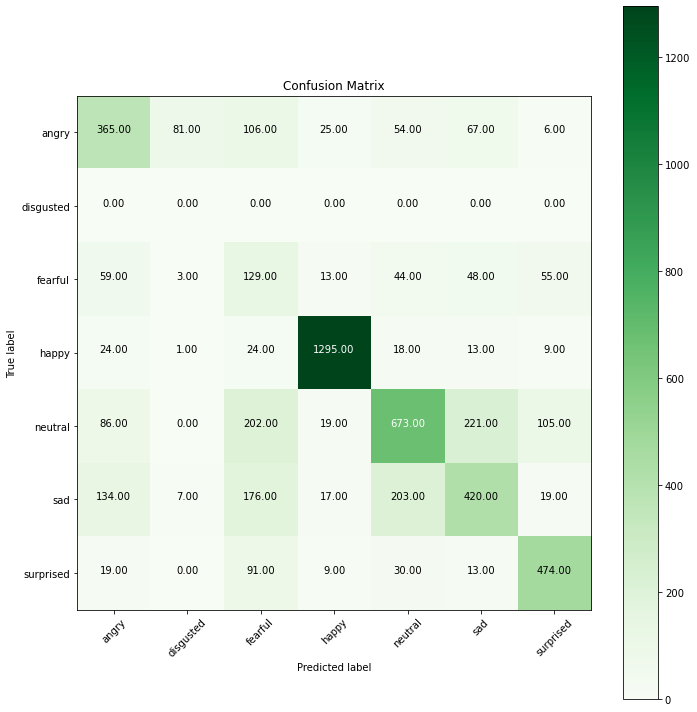

In [38]:
# Confusion matrix
DefinedCNN.visualise_confusion_matrix(plt.cm.Greens)

